In [1]:
%matplotlib inline

In [2]:
# Dependencies
import pandas as pd
import numpy as np
import requests
import json
import time
import matplotlib.pyplot as plt
# Google API Key
from config import gkey

In [3]:
# Create a list of times to find commute duration for
times_list_to_work = [5,6,7,8,9,10,11,12]
times_list_to_home = [13,14,15,16,17,18,19]
dates_list = ['3/2/2020','3/3/2020','3/4/2020','3/5/2020','3/6/2020','3/7/2020','3/8/2020']
home_location = 'Moffett Field'
work_location = 'Salesforce Tower'

In [4]:
# create a new list with combined dates/times into epoch time to be used to query database
pattern = '%m/%d/%Y-%H'
date_string = ''
datetime_list_to_work = []
datetime_list_to_home = []
times_df = pd.DataFrame(columns=["Commute Date", "Commute Start", "Epoch Time"])

for date_in in dates_list:
    
    for time_in in times_list_to_work:
        date_string = date_in + '-' + str(time_in)
        epoch = int(time.mktime(time.strptime(date_string, pattern)))
        datetime_list_to_work.append(epoch)
        times_df = times_df.append({
             "Commute Date": date_in,
             "Commute Start": time_in,
             "Epoch Time": epoch
          }, ignore_index=True)
        
    for time_in in times_list_to_home:
        date_string = date_in + '-' + str(time_in)
        epoch = int(time.mktime(time.strptime(date_string, pattern)))
        datetime_list_to_home.append(epoch)
        times_df = times_df.append({
             "Commute Date": date_in,
             "Commute Start": time_in,
             "Epoch Time": epoch
          }, ignore_index=True)

In [5]:
print(datetime_list_to_work)
print(datetime_list_to_home)
times_df.head()

[1583154000, 1583157600, 1583161200, 1583164800, 1583168400, 1583172000, 1583175600, 1583179200, 1583240400, 1583244000, 1583247600, 1583251200, 1583254800, 1583258400, 1583262000, 1583265600, 1583326800, 1583330400, 1583334000, 1583337600, 1583341200, 1583344800, 1583348400, 1583352000, 1583413200, 1583416800, 1583420400, 1583424000, 1583427600, 1583431200, 1583434800, 1583438400, 1583499600, 1583503200, 1583506800, 1583510400, 1583514000, 1583517600, 1583521200, 1583524800, 1583586000, 1583589600, 1583593200, 1583596800, 1583600400, 1583604000, 1583607600, 1583611200, 1583668800, 1583672400, 1583676000, 1583679600, 1583683200, 1583686800, 1583690400, 1583694000]
[1583182800, 1583186400, 1583190000, 1583193600, 1583197200, 1583200800, 1583204400, 1583269200, 1583272800, 1583276400, 1583280000, 1583283600, 1583287200, 1583290800, 1583355600, 1583359200, 1583362800, 1583366400, 1583370000, 1583373600, 1583377200, 1583442000, 1583445600, 1583449200, 1583452800, 1583456400, 1583460000, 15

,Commute Date,Commute Start,Epoch Time
0,3/2/2020,5,1583154000
1,3/2/2020,6,1583157600
2,3/2/2020,7,1583161200
3,3/2/2020,8,1583164800
4,3/2/2020,9,1583168400


In [6]:
def get_commute_times(start_point, end_point, datetime_list):
    # Base info for google maps direction request
    # create a params dict that will be updated for each date/time
    params = {"key": gkey}
    base_url = "https://maps.googleapis.com/maps/api/directions/json"
    params['mode'] = 'driving'
    params['origin'] = start_point
    params['destination'] = end_point

    # Create dictionary to store {date_time: commute_time}
    commute_dict = {}
    
    # Loop through the date/times to get the period you are going to search for
    for commute_start in datetime_list:

        # update address key value
        params['departure_time'] = commute_start

        # make request
        commute_info = requests.get(base_url, params=params)
    
        # convert to json
        commute_info = commute_info.json()
    
        commute_time_legs = commute_info['routes'][0]['legs']
        total_route_time = 0
        for c_time in commute_time_legs:
            total_route_time = total_route_time + c_time['duration_in_traffic']['value']

        commute_dict[commute_start] = total_route_time
        time_here = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(commute_start))
        # print(f"Commute duration from {start_point} to {end_point} for {time_here} = {total_route_time/60} minutes")

        
    return commute_dict
    

In [7]:
# Get commute times for going to work
commute_to_work_dict = get_commute_times(home_location, work_location, datetime_list_to_work)

In [8]:
# Create dataframe to store commute data
commute_to_work_df = pd.DataFrame.from_dict(commute_to_work_dict, orient='index', columns=['Commute Time'])
commute_to_work_df.index.name = 'Epoch Time'
commute_to_work_df.head()

,Commute Time
Epoch Time,
1583154000,2500
1583157600,2772
1583161200,3870
1583164800,4416
1583168400,3781


In [9]:
# Get commute times for going home
commute_to_home_dict = get_commute_times(work_location, home_location, datetime_list_to_home)

In [10]:
# Create dataframe to store commute data
commute_to_home_df = pd.DataFrame.from_dict(commute_to_home_dict, orient='index', columns=['Commute Time'])
commute_to_home_df.index.name = 'Epoch Time'
commute_to_home_df.head()

,Commute Time
Epoch Time,
1583182800,2919
1583186400,3194
1583190000,3530
1583193600,3671
1583197200,4039


In [11]:
commute_to_work_df = pd.merge(commute_to_work_df,
                 times_df[['Commute Date', 'Commute Start', 'Epoch Time']],
                 on='Epoch Time')
commute_to_work_df.head()

,Epoch Time,Commute Time,Commute Date,Commute Start
0,1583154000,2500,3/2/2020,5
1,1583157600,2772,3/2/2020,6
2,1583161200,3870,3/2/2020,7
3,1583164800,4416,3/2/2020,8
4,1583168400,3781,3/2/2020,9


In [12]:
commute_to_home_df = pd.merge(commute_to_home_df,
                 times_df[['Commute Date', 'Commute Start', 'Epoch Time']],
                 on='Epoch Time')
commute_to_home_df.head()

,Epoch Time,Commute Time,Commute Date,Commute Start
0,1583182800,2919,3/2/2020,13
1,1583186400,3194,3/2/2020,14
2,1583190000,3530,3/2/2020,15
3,1583193600,3671,3/2/2020,16
4,1583197200,4039,3/2/2020,17


In [13]:
# Add Commute To/From info as a column
commute_to_work_df['Commute Name'] = f"{home_location } to {work_location}"
commute_to_work_df.head()

,Epoch Time,Commute Time,Commute Date,Commute Start,Commute Name
0,1583154000,2500,3/2/2020,5,Moffett Field to Salesforce Tower
1,1583157600,2772,3/2/2020,6,Moffett Field to Salesforce Tower
2,1583161200,3870,3/2/2020,7,Moffett Field to Salesforce Tower
3,1583164800,4416,3/2/2020,8,Moffett Field to Salesforce Tower
4,1583168400,3781,3/2/2020,9,Moffett Field to Salesforce Tower


In [14]:
commute_to_home_df['Commute Name'] = f"{work_location} to {home_location}"
commute_to_home_df.head()

,Epoch Time,Commute Time,Commute Date,Commute Start,Commute Name
0,1583182800,2919,3/2/2020,13,Salesforce Tower to Moffett Field
1,1583186400,3194,3/2/2020,14,Salesforce Tower to Moffett Field
2,1583190000,3530,3/2/2020,15,Salesforce Tower to Moffett Field
3,1583193600,3671,3/2/2020,16,Salesforce Tower to Moffett Field
4,1583197200,4039,3/2/2020,17,Salesforce Tower to Moffett Field


In [15]:
# Save Data to csv
commute_to_work_df.to_csv('commute_to_work.csv')
commute_to_home_df.to_csv('commute_to_home.csv')

In [31]:
# Create csv file to store home and work locations for use in visualization Jupyter Notebook
data = [[home_location, work_location]]
commute_locations_df = pd.DataFrame(data, columns = ['home_location', 'work_location'])
print(commute_locations_df)
commute_locations_df.to_csv('commute_locations.csv') 

   home_location     work_location
0  Moffett Field  Salesforce Tower


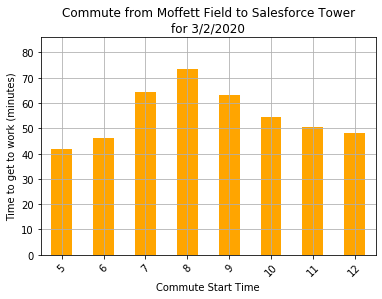

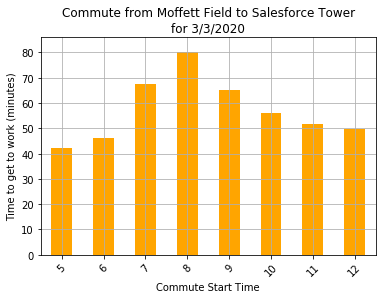

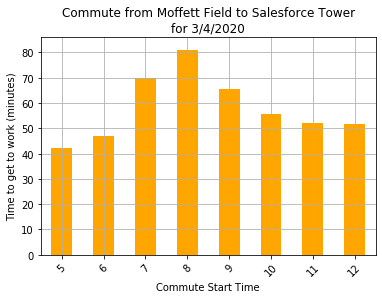

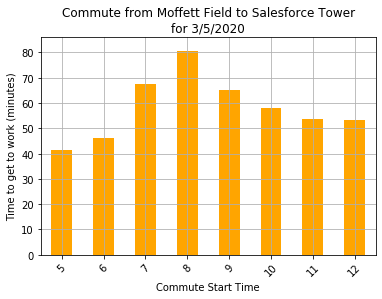

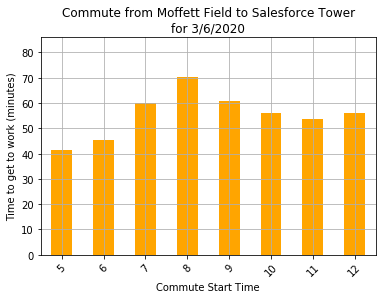

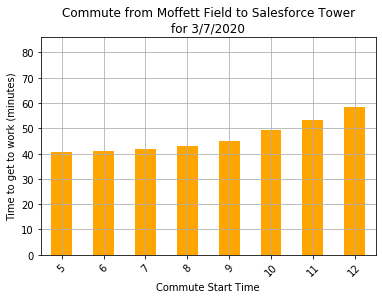

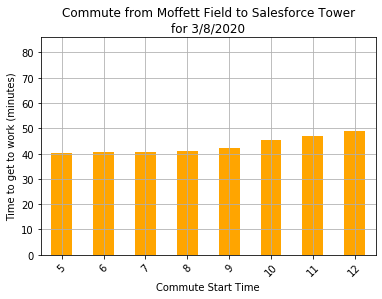

In [25]:
# Going to work...
# Create 7 bar charts, one for each day of week, with start times we have stored as x-axis 
# and commute time in minutes as y-axis
s_times_list_to_work = [str(item) for item in times_list_to_work]
y_Max = round(commute_to_work_df['Commute Time'].max()/60)
#print(y_Max)
for day in dates_list:
    commute_to_plot_df = commute_to_work_df[commute_to_work_df['Commute Date'] == day]
    work_trips = commute_to_plot_df['Commute Time']/60
    work_times = work_trips.plot(kind="bar", title= f"Commute from {home_location} to {work_location}\nfor {day}", color="orange",rot=45)
    work_times.set_xlabel("Commute Start Time (AM)")
    work_times.set_ylabel("Time to get to work (minutes)")
    work_times.set_xticklabels(s_times_list_to_work)
    work_times.set_ylim(0, y_Max+5)
    work_times.grid(b=True)
    plt.show()

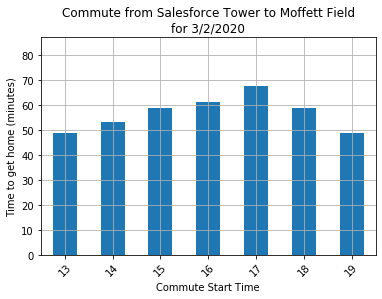

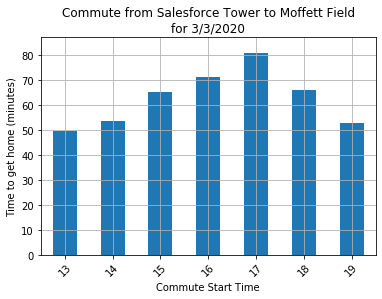

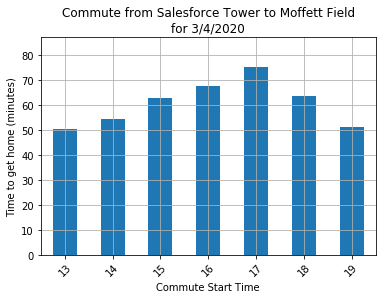

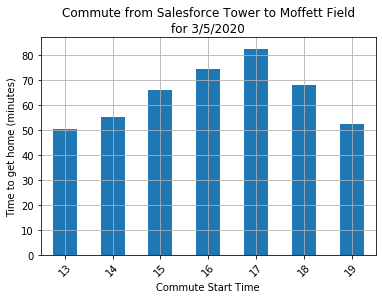

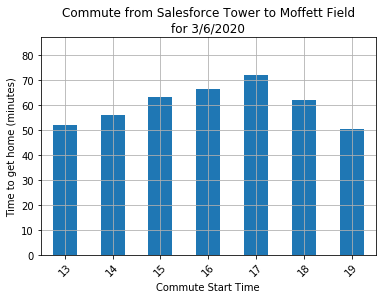

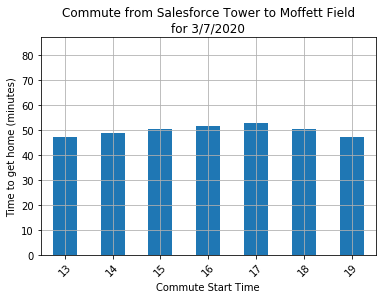

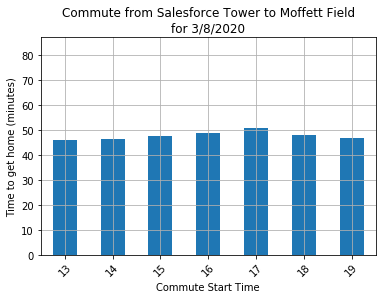

In [28]:
# Going Home...
# Create 7 bar charts, one for each day of week, with start times we have stored as x-axis 
# and commute time in minutes as y-axis
s_times_list_to_home = [str(item) for item in times_list_to_home]
y_Max = round(commute_to_home_df['Commute Time'].max()/60)
#print(y_Max)
for day in dates_list:
    commute_to_plot_df = commute_to_home_df[commute_to_home_df['Commute Date'] == day]
    work_trips = commute_to_plot_df['Commute Time']/60
    work_times = work_trips.plot(kind="bar", title= f"Commute from {work_location} to {home_location}\nfor {day}",rot=45)
    work_times.set_xlabel("Commute Start Time (PM)")
    work_times.set_ylabel("Time to get home (minutes)")
    work_times.set_xticklabels(s_times_list_to_home)
    work_times.set_ylim(0, y_Max+5)
    work_times.grid(b=True)
    plt.show()
